# Machine Learning Power Measurement

In this notebook, we will use the NVidia Management Library to sample power draw and GPU utilization during training of a CIFAR-10 convolutional network. 

### `NvidiaMLWrapper`

We need to be able to query hardware GPU data. This class wraps `pynvml`, which is a library of Python bindings for the [NVIDIA Management Library (NVML)](https://developer.nvidia.com/nvidia-management-library-nvml).

In [1]:
from pynvml import *

class NvidiaMLWrapper:

    handles = dict()
    def __init__(self):
        nvmlInit()
        for i in range(nvmlDeviceGetCount()):
            self.handles['gpu' + str(i)] = nvmlDeviceGetHandleByIndex(i)
            
    def get_sample(self):
        sample = dict()
        for gpu_name, handle in self.handles.items():
            sample[gpu_name] = dict()
            sample[gpu_name]['power_usage'] = nvmlDeviceGetPowerUsage(handle)
            utilization = nvmlDeviceGetUtilizationRates(handle)
            sample[gpu_name]['gpu_utilization'] = utilization.gpu
            sample[gpu_name]['memory_utilization'] = utilization.memory
        return sample
        
    def __del__(self):
        nvmlShutdown()

### `get_stdout_queue` and other functions

These are some utility functions we can use to capture sample data, including `get_stdout_queue`. `get_stdout_queue` returns a synchronized queue that uses a separate thread to capture data from a `stdout` buffer. We will use it to  capture output from a Python `subprocess` in a non-blocking fashion.

In [2]:
def save_samples(samples, filename):
    import json    
    with open(filename, 'w') as f:
        for sample in samples:
            f.write(json.dumps(sample))
            f.write("\n")
        f.close()

def load_samples(filename):
    import json
    with open(filename, 'r') as f:
        return [ json.loads(sample.strip()) for sample in f.readlines() ]

def epoch_milliseconds():
    return int(round(time.time() * 1000))

def get_stdout_queue(stdout):
    from threading import Thread
    from Queue import Queue, Empty
    
    def enqueue_output(out, queue):
        for line in iter(out.readline, b''):
            queue.put(line)
        out.close()

    # Use a synchronized queue and separate thread to run and retrieve output from cifar10_train.py
    q = Queue()
    global _stdout_thread
    _stdout_thread = Thread(target=enqueue_output, args=(stdout, q))
    _stdout_thread.daemon = True # thread dies with the program
    _stdout_thread.start()
    return q

### Measuring power for `cifar10_train.py`

To measure power consumption for `cifar10_train.py` and to collect power samples during execution, we will use a synchornized `Queue` to capture output from a subprocess that is running the `cifar10_train.py` training script. Whenever there is a new line of output from `cifar10_train.py`, we will parse the output as metadata, take a power sample and timestamp it. The end result is a list of timestamped power samples with training metadata from `cifar10_train.py`.

For time purposes, we will run this training for only 5000 steps.

_*Acknolwedgements to [http://stackoverflow.com/a/4896288/6939184](http://stackoverflow.com/a/4896288/6939184)*_

In [3]:
import sys
import time
from subprocess import PIPE, Popen
from Queue import Queue, Empty
import subprocess

ON_POSIX = 'posix' in sys.builtin_module_names

# Start cifar10_train.py with no Python output buffering
cifar10_process = subprocess.Popen(['python', '-u', './models/tutorials/image/cifar10/cifar10_multi_gpu_train.py'],
                                   stdout=subprocess.PIPE,
                                   close_fds=ON_POSIX)

cifar10_results = list()
start = epoch_milliseconds()

q = get_stdout_queue(cifar10_process.stdout)

nvml = NvidiaMLWrapper()

step = 0

while step < 5000:
    # Check the synchronized queue for new output
    try:  
        line = q.get_nowait()
    except Empty:
        pass
    else:
        # If there is output and it's not the first line that says it is loading sample data
        if "Filling" not in line:
            
            # Parse the cifar10_train.py training output
            step = float(line.split("step ")[1].split(",")[0])
            loss = float(line.split("loss = ")[1].split()[0])
            examples_sec = float(line.split("(")[1].split()[0])
            sec_batch = float(line.split("examples/sec; ")[1].split()[0])

            # Save the cifar10_train.py training output as metadata
            cifar10 = dict();
            cifar10['step'] = step
            cifar10['loss'] = loss
            cifar10['examples_sec'] = examples_sec
            cifar10['sec_batch'] = sec_batch

            # Get a sample from nvidia_smi
            #sample = query_smi(nvidia_smi_parameters)
            sample = nvml.get_sample()
            
            # Timestamp the sample
            sample['ms'] = epoch_milliseconds() - start
            
            # Save the cifar10_train.py generation metadata
            sample['metadata'] = cifar10
            
            # Save the sample
            cifar10_results.append(sample)
            print sample
            
    # Sleep between checking for new output
    time.sleep(0.1)
        
cifar10_process.kill()

save_samples(cifar10_results, "cifar10_multi_gpu_samples.txt")

{'gpu0': {'gpu_utilization': 25L, 'memory_utilization': 9L, 'power_usage': 47581L}, 'gpu1': {'gpu_utilization': 0L, 'memory_utilization': 0L, 'power_usage': 32260L}, 'ms': 17646, 'metadata': {'loss': 4.68, 'step': 0.0, 'examples_sec': 8.6, 'sec_batch': 14.929}}
{'gpu0': {'gpu_utilization': 35L, 'memory_utilization': 16L, 'power_usage': 42729L}, 'gpu1': {'gpu_utilization': 0L, 'memory_utilization': 0L, 'power_usage': 32260L}, 'ms': 18654, 'metadata': {'loss': 4.6, 'step': 10.0, 'examples_sec': 1295.6, 'sec_batch': 0.099}}
{'gpu0': {'gpu_utilization': 32L, 'memory_utilization': 11L, 'power_usage': 41053L}, 'gpu1': {'gpu_utilization': 0L, 'memory_utilization': 0L, 'power_usage': 32260L}, 'ms': 19662, 'metadata': {'loss': 4.46, 'step': 20.0, 'examples_sec': 1289.8, 'sec_batch': 0.099}}
{'gpu0': {'gpu_utilization': 34L, 'memory_utilization': 14L, 'power_usage': 42049L}, 'gpu1': {'gpu_utilization': 0L, 'memory_utilization': 0L, 'power_usage': 32282L}, 'ms': 20570, 'metadata': {'loss': 4.36, 

{'gpu0': {'gpu_utilization': 35L, 'memory_utilization': 16L, 'power_usage': 40325L}, 'gpu1': {'gpu_utilization': 0L, 'memory_utilization': 0L, 'power_usage': 32260L}, 'ms': 47724, 'metadata': {'loss': 3.45, 'step': 310.0, 'examples_sec': 1369.2, 'sec_batch': 0.093}}
{'gpu0': {'gpu_utilization': 35L, 'memory_utilization': 14L, 'power_usage': 37410L}, 'gpu1': {'gpu_utilization': 0L, 'memory_utilization': 0L, 'power_usage': 32282L}, 'ms': 48734, 'metadata': {'loss': 3.58, 'step': 320.0, 'examples_sec': 1380.9, 'sec_batch': 0.093}}
{'gpu0': {'gpu_utilization': 37L, 'memory_utilization': 16L, 'power_usage': 44211L}, 'gpu1': {'gpu_utilization': 0L, 'memory_utilization': 0L, 'power_usage': 32260L}, 'ms': 49642, 'metadata': {'loss': 3.56, 'step': 330.0, 'examples_sec': 1254.0, 'sec_batch': 0.102}}
{'gpu0': {'gpu_utilization': 35L, 'memory_utilization': 16L, 'power_usage': 49042L}, 'gpu1': {'gpu_utilization': 0L, 'memory_utilization': 0L, 'power_usage': 32282L}, 'ms': 50553, 'metadata': {'loss'

{'gpu0': {'gpu_utilization': 37L, 'memory_utilization': 16L, 'power_usage': 38381L}, 'gpu1': {'gpu_utilization': 0L, 'memory_utilization': 0L, 'power_usage': 32039L}, 'ms': 77707, 'metadata': {'loss': 2.82, 'step': 620.0, 'examples_sec': 1483.8, 'sec_batch': 0.086}}
{'gpu0': {'gpu_utilization': 34L, 'memory_utilization': 15L, 'power_usage': 39596L}, 'gpu1': {'gpu_utilization': 0L, 'memory_utilization': 0L, 'power_usage': 32282L}, 'ms': 78615, 'metadata': {'loss': 3.05, 'step': 630.0, 'examples_sec': 1194.3, 'sec_batch': 0.107}}
{'gpu0': {'gpu_utilization': 35L, 'memory_utilization': 16L, 'power_usage': 41782L}, 'gpu1': {'gpu_utilization': 0L, 'memory_utilization': 0L, 'power_usage': 32282L}, 'ms': 79625, 'metadata': {'loss': 2.86, 'step': 640.0, 'examples_sec': 1402.5, 'sec_batch': 0.091}}
{'gpu0': {'gpu_utilization': 35L, 'memory_utilization': 16L, 'power_usage': 39353L}, 'gpu1': {'gpu_utilization': 0L, 'memory_utilization': 0L, 'power_usage': 32282L}, 'ms': 80633, 'metadata': {'loss'

{'gpu0': {'gpu_utilization': 35L, 'memory_utilization': 16L, 'power_usage': 42754L}, 'gpu1': {'gpu_utilization': 0L, 'memory_utilization': 0L, 'power_usage': 32260L}, 'ms': 107886, 'metadata': {'loss': 2.49, 'step': 930.0, 'examples_sec': 1410.7, 'sec_batch': 0.091}}
{'gpu0': {'gpu_utilization': 35L, 'memory_utilization': 16L, 'power_usage': 39839L}, 'gpu1': {'gpu_utilization': 0L, 'memory_utilization': 0L, 'power_usage': 32282L}, 'ms': 108797, 'metadata': {'loss': 2.69, 'step': 940.0, 'examples_sec': 1474.1, 'sec_batch': 0.087}}
{'gpu0': {'gpu_utilization': 35L, 'memory_utilization': 16L, 'power_usage': 41782L}, 'gpu1': {'gpu_utilization': 0L, 'memory_utilization': 0L, 'power_usage': 32282L}, 'ms': 109705, 'metadata': {'loss': 2.59, 'step': 950.0, 'examples_sec': 1372.7, 'sec_batch': 0.093}}
{'gpu0': {'gpu_utilization': 33L, 'memory_utilization': 16L, 'power_usage': 40834L}, 'gpu1': {'gpu_utilization': 0L, 'memory_utilization': 0L, 'power_usage': 32282L}, 'ms': 110615, 'metadata': {'l

{'gpu0': {'gpu_utilization': 36L, 'memory_utilization': 16L, 'power_usage': 40568L}, 'gpu1': {'gpu_utilization': 0L, 'memory_utilization': 0L, 'power_usage': 32282L}, 'ms': 137671, 'metadata': {'loss': 2.27, 'step': 1240.0, 'examples_sec': 1452.1, 'sec_batch': 0.088}}
{'gpu0': {'gpu_utilization': 33L, 'memory_utilization': 14L, 'power_usage': 39353L}, 'gpu1': {'gpu_utilization': 0L, 'memory_utilization': 0L, 'power_usage': 32282L}, 'ms': 138579, 'metadata': {'loss': 2.3, 'step': 1250.0, 'examples_sec': 1354.0, 'sec_batch': 0.095}}
{'gpu0': {'gpu_utilization': 34L, 'memory_utilization': 16L, 'power_usage': 41296L}, 'gpu1': {'gpu_utilization': 0L, 'memory_utilization': 0L, 'power_usage': 32282L}, 'ms': 139589, 'metadata': {'loss': 2.05, 'step': 1260.0, 'examples_sec': 1303.3, 'sec_batch': 0.098}}
{'gpu0': {'gpu_utilization': 31L, 'memory_utilization': 10L, 'power_usage': 52653L}, 'gpu1': {'gpu_utilization': 0L, 'memory_utilization': 0L, 'power_usage': 32260L}, 'ms': 140497, 'metadata': {

{'gpu0': {'gpu_utilization': 34L, 'memory_utilization': 16L, 'power_usage': 39619L}, 'gpu1': {'gpu_utilization': 0L, 'memory_utilization': 0L, 'power_usage': 32282L}, 'ms': 167551, 'metadata': {'loss': 1.99, 'step': 1550.0, 'examples_sec': 1335.4, 'sec_batch': 0.096}}
{'gpu0': {'gpu_utilization': 35L, 'memory_utilization': 16L, 'power_usage': 44211L}, 'gpu1': {'gpu_utilization': 0L, 'memory_utilization': 0L, 'power_usage': 32282L}, 'ms': 168462, 'metadata': {'loss': 1.93, 'step': 1560.0, 'examples_sec': 1272.4, 'sec_batch': 0.101}}
{'gpu0': {'gpu_utilization': 32L, 'memory_utilization': 11L, 'power_usage': 51716L}, 'gpu1': {'gpu_utilization': 0L, 'memory_utilization': 0L, 'power_usage': 32018L}, 'ms': 169469, 'metadata': {'loss': 1.9, 'step': 1570.0, 'examples_sec': 1445.5, 'sec_batch': 0.089}}
{'gpu0': {'gpu_utilization': 36L, 'memory_utilization': 16L, 'power_usage': 55592L}, 'gpu1': {'gpu_utilization': 0L, 'memory_utilization': 0L, 'power_usage': 32260L}, 'ms': 170279, 'metadata': {

{'gpu0': {'gpu_utilization': 34L, 'memory_utilization': 13L, 'power_usage': 47126L}, 'gpu1': {'gpu_utilization': 0L, 'memory_utilization': 0L, 'power_usage': 32282L}, 'ms': 197333, 'metadata': {'loss': 1.52, 'step': 1860.0, 'examples_sec': 1351.4, 'sec_batch': 0.095}}
{'gpu0': {'gpu_utilization': 36L, 'memory_utilization': 16L, 'power_usage': 62637L}, 'gpu1': {'gpu_utilization': 0L, 'memory_utilization': 0L, 'power_usage': 32260L}, 'ms': 198240, 'metadata': {'loss': 1.56, 'step': 1870.0, 'examples_sec': 1453.5, 'sec_batch': 0.088}}
{'gpu0': {'gpu_utilization': 32L, 'memory_utilization': 15L, 'power_usage': 58685L}, 'gpu1': {'gpu_utilization': 0L, 'memory_utilization': 0L, 'power_usage': 32260L}, 'ms': 199251, 'metadata': {'loss': 1.81, 'step': 1880.0, 'examples_sec': 1141.9, 'sec_batch': 0.112}}
{'gpu0': {'gpu_utilization': 33L, 'memory_utilization': 13L, 'power_usage': 41053L}, 'gpu1': {'gpu_utilization': 0L, 'memory_utilization': 0L, 'power_usage': 32282L}, 'ms': 200159, 'metadata': 

{'gpu0': {'gpu_utilization': 33L, 'memory_utilization': 16L, 'power_usage': 40811L}, 'gpu1': {'gpu_utilization': 0L, 'memory_utilization': 0L, 'power_usage': 32282L}, 'ms': 227113, 'metadata': {'loss': 1.54, 'step': 2170.0, 'examples_sec': 1123.4, 'sec_batch': 0.114}}
{'gpu0': {'gpu_utilization': 34L, 'memory_utilization': 16L, 'power_usage': 40082L}, 'gpu1': {'gpu_utilization': 0L, 'memory_utilization': 0L, 'power_usage': 32282L}, 'ms': 228123, 'metadata': {'loss': 1.75, 'step': 2180.0, 'examples_sec': 1348.8, 'sec_batch': 0.095}}
{'gpu0': {'gpu_utilization': 31L, 'memory_utilization': 11L, 'power_usage': 40834L}, 'gpu1': {'gpu_utilization': 0L, 'memory_utilization': 0L, 'power_usage': 32282L}, 'ms': 229030, 'metadata': {'loss': 1.51, 'step': 2190.0, 'examples_sec': 1281.1, 'sec_batch': 0.1}}
{'gpu0': {'gpu_utilization': 37L, 'memory_utilization': 16L, 'power_usage': 44211L}, 'gpu1': {'gpu_utilization': 0L, 'memory_utilization': 0L, 'power_usage': 32282L}, 'ms': 229941, 'metadata': {'

{'gpu0': {'gpu_utilization': 34L, 'memory_utilization': 16L, 'power_usage': 40082L}, 'gpu1': {'gpu_utilization': 0L, 'memory_utilization': 0L, 'power_usage': 32282L}, 'ms': 256995, 'metadata': {'loss': 1.36, 'step': 2480.0, 'examples_sec': 1460.8, 'sec_batch': 0.088}}
{'gpu0': {'gpu_utilization': 37L, 'memory_utilization': 16L, 'power_usage': 41539L}, 'gpu1': {'gpu_utilization': 0L, 'memory_utilization': 0L, 'power_usage': 32282L}, 'ms': 257902, 'metadata': {'loss': 1.29, 'step': 2490.0, 'examples_sec': 1459.0, 'sec_batch': 0.088}}
{'gpu0': {'gpu_utilization': 31L, 'memory_utilization': 14L, 'power_usage': 43726L}, 'gpu1': {'gpu_utilization': 0L, 'memory_utilization': 0L, 'power_usage': 32282L}, 'ms': 258913, 'metadata': {'loss': 1.31, 'step': 2500.0, 'examples_sec': 1289.3, 'sec_batch': 0.099}}
{'gpu0': {'gpu_utilization': 33L, 'memory_utilization': 13L, 'power_usage': 45912L}, 'gpu1': {'gpu_utilization': 0L, 'memory_utilization': 0L, 'power_usage': 32282L}, 'ms': 259920, 'metadata': 

{'gpu0': {'gpu_utilization': 33L, 'memory_utilization': 16L, 'power_usage': 40568L}, 'gpu1': {'gpu_utilization': 0L, 'memory_utilization': 0L, 'power_usage': 32282L}, 'ms': 286774, 'metadata': {'loss': 1.18, 'step': 2790.0, 'examples_sec': 1353.0, 'sec_batch': 0.095}}
{'gpu0': {'gpu_utilization': 34L, 'memory_utilization': 16L, 'power_usage': 41077L}, 'gpu1': {'gpu_utilization': 0L, 'memory_utilization': 0L, 'power_usage': 32282L}, 'ms': 287785, 'metadata': {'loss': 1.25, 'step': 2800.0, 'examples_sec': 1491.0, 'sec_batch': 0.086}}
{'gpu0': {'gpu_utilization': 33L, 'memory_utilization': 13L, 'power_usage': 56082L}, 'gpu1': {'gpu_utilization': 0L, 'memory_utilization': 0L, 'power_usage': 32260L}, 'ms': 288793, 'metadata': {'loss': 1.35, 'step': 2810.0, 'examples_sec': 1430.6, 'sec_batch': 0.089}}
{'gpu0': {'gpu_utilization': 37L, 'memory_utilization': 16L, 'power_usage': 47126L}, 'gpu1': {'gpu_utilization': 0L, 'memory_utilization': 0L, 'power_usage': 32282L}, 'ms': 289803, 'metadata': 

{'gpu0': {'gpu_utilization': 34L, 'memory_utilization': 14L, 'power_usage': 39353L}, 'gpu1': {'gpu_utilization': 0L, 'memory_utilization': 0L, 'power_usage': 32282L}, 'ms': 316657, 'metadata': {'loss': 1.2, 'step': 3100.0, 'examples_sec': 1297.0, 'sec_batch': 0.099}}
{'gpu0': {'gpu_utilization': 35L, 'memory_utilization': 16L, 'power_usage': 43483L}, 'gpu1': {'gpu_utilization': 0L, 'memory_utilization': 0L, 'power_usage': 32282L}, 'ms': 317665, 'metadata': {'loss': 1.18, 'step': 3110.0, 'examples_sec': 1437.3, 'sec_batch': 0.089}}
{'gpu0': {'gpu_utilization': 34L, 'memory_utilization': 16L, 'power_usage': 44454L}, 'gpu1': {'gpu_utilization': 0L, 'memory_utilization': 0L, 'power_usage': 32524L}, 'ms': 318575, 'metadata': {'loss': 1.14, 'step': 3120.0, 'examples_sec': 1169.3, 'sec_batch': 0.109}}
{'gpu0': {'gpu_utilization': 34L, 'memory_utilization': 16L, 'power_usage': 39839L}, 'gpu1': {'gpu_utilization': 0L, 'memory_utilization': 0L, 'power_usage': 32282L}, 'ms': 319683, 'metadata': {

{'gpu0': {'gpu_utilization': 32L, 'memory_utilization': 14L, 'power_usage': 43240L}, 'gpu1': {'gpu_utilization': 0L, 'memory_utilization': 0L, 'power_usage': 32282L}, 'ms': 346737, 'metadata': {'loss': 1.03, 'step': 3410.0, 'examples_sec': 1313.7, 'sec_batch': 0.097}}
{'gpu0': {'gpu_utilization': 35L, 'memory_utilization': 16L, 'power_usage': 40348L}, 'gpu1': {'gpu_utilization': 0L, 'memory_utilization': 0L, 'power_usage': 32282L}, 'ms': 347747, 'metadata': {'loss': 1.25, 'step': 3420.0, 'examples_sec': 1439.6, 'sec_batch': 0.089}}
{'gpu0': {'gpu_utilization': 35L, 'memory_utilization': 16L, 'power_usage': 42049L}, 'gpu1': {'gpu_utilization': 0L, 'memory_utilization': 0L, 'power_usage': 32282L}, 'ms': 348655, 'metadata': {'loss': 1.02, 'step': 3430.0, 'examples_sec': 1289.8, 'sec_batch': 0.099}}
{'gpu0': {'gpu_utilization': 31L, 'memory_utilization': 10L, 'power_usage': 53628L}, 'gpu1': {'gpu_utilization': 0L, 'memory_utilization': 0L, 'power_usage': 32282L}, 'ms': 349665, 'metadata': 

{'gpu0': {'gpu_utilization': 34L, 'memory_utilization': 16L, 'power_usage': 49313L}, 'gpu1': {'gpu_utilization': 0L, 'memory_utilization': 0L, 'power_usage': 32524L}, 'ms': 376600, 'metadata': {'loss': 1.36, 'step': 3720.0, 'examples_sec': 1438.0, 'sec_batch': 0.089}}
{'gpu0': {'gpu_utilization': 34L, 'memory_utilization': 14L, 'power_usage': 39839L}, 'gpu1': {'gpu_utilization': 0L, 'memory_utilization': 0L, 'power_usage': 32282L}, 'ms': 377608, 'metadata': {'loss': 1.13, 'step': 3730.0, 'examples_sec': 1423.3, 'sec_batch': 0.09}}
{'gpu0': {'gpu_utilization': 36L, 'memory_utilization': 16L, 'power_usage': 50494L}, 'gpu1': {'gpu_utilization': 0L, 'memory_utilization': 0L, 'power_usage': 32260L}, 'ms': 378518, 'metadata': {'loss': 1.21, 'step': 3740.0, 'examples_sec': 1542.3, 'sec_batch': 0.083}}
{'gpu0': {'gpu_utilization': 30L, 'memory_utilization': 10L, 'power_usage': 42268L}, 'gpu1': {'gpu_utilization': 0L, 'memory_utilization': 0L, 'power_usage': 32282L}, 'ms': 379425, 'metadata': {

{'gpu0': {'gpu_utilization': 36L, 'memory_utilization': 16L, 'power_usage': 44940L}, 'gpu1': {'gpu_utilization': 0L, 'memory_utilization': 0L, 'power_usage': 32282L}, 'ms': 406480, 'metadata': {'loss': 1.18, 'step': 4030.0, 'examples_sec': 1440.0, 'sec_batch': 0.089}}
{'gpu0': {'gpu_utilization': 33L, 'memory_utilization': 16L, 'power_usage': 55807L}, 'gpu1': {'gpu_utilization': 0L, 'memory_utilization': 0L, 'power_usage': 32282L}, 'ms': 407390, 'metadata': {'loss': 1.01, 'step': 4040.0, 'examples_sec': 1369.0, 'sec_batch': 0.094}}
{'gpu0': {'gpu_utilization': 33L, 'memory_utilization': 13L, 'power_usage': 39376L}, 'gpu1': {'gpu_utilization': 0L, 'memory_utilization': 0L, 'power_usage': 32282L}, 'ms': 408398, 'metadata': {'loss': 1.02, 'step': 4050.0, 'examples_sec': 1338.4, 'sec_batch': 0.096}}
{'gpu0': {'gpu_utilization': 33L, 'memory_utilization': 16L, 'power_usage': 60145L}, 'gpu1': {'gpu_utilization': 0L, 'memory_utilization': 0L, 'power_usage': 32282L}, 'ms': 409408, 'metadata': 

{'gpu0': {'gpu_utilization': 35L, 'memory_utilization': 16L, 'power_usage': 46641L}, 'gpu1': {'gpu_utilization': 0L, 'memory_utilization': 0L, 'power_usage': 32260L}, 'ms': 436462, 'metadata': {'loss': 1.02, 'step': 4340.0, 'examples_sec': 1470.8, 'sec_batch': 0.087}}
{'gpu0': {'gpu_utilization': 32L, 'memory_utilization': 12L, 'power_usage': 40348L}, 'gpu1': {'gpu_utilization': 0L, 'memory_utilization': 0L, 'power_usage': 32282L}, 'ms': 437369, 'metadata': {'loss': 1.0, 'step': 4350.0, 'examples_sec': 1436.4, 'sec_batch': 0.089}}
{'gpu0': {'gpu_utilization': 37L, 'memory_utilization': 16L, 'power_usage': 40105L}, 'gpu1': {'gpu_utilization': 0L, 'memory_utilization': 0L, 'power_usage': 32282L}, 'ms': 438277, 'metadata': {'loss': 1.18, 'step': 4360.0, 'examples_sec': 1568.6, 'sec_batch': 0.082}}
{'gpu0': {'gpu_utilization': 33L, 'memory_utilization': 16L, 'power_usage': 43508L}, 'gpu1': {'gpu_utilization': 0L, 'memory_utilization': 0L, 'power_usage': 32282L}, 'ms': 439285, 'metadata': {

{'gpu0': {'gpu_utilization': 37L, 'memory_utilization': 16L, 'power_usage': 41320L}, 'gpu1': {'gpu_utilization': 0L, 'memory_utilization': 0L, 'power_usage': 32524L}, 'ms': 466133, 'metadata': {'loss': 1.1, 'step': 4650.0, 'examples_sec': 1437.5, 'sec_batch': 0.089}}
{'gpu0': {'gpu_utilization': 33L, 'memory_utilization': 16L, 'power_usage': 58719L}, 'gpu1': {'gpu_utilization': 0L, 'memory_utilization': 0L, 'power_usage': 32282L}, 'ms': 467041, 'metadata': {'loss': 1.06, 'step': 4660.0, 'examples_sec': 1196.0, 'sec_batch': 0.107}}
{'gpu0': {'gpu_utilization': 35L, 'memory_utilization': 16L, 'power_usage': 40814L}, 'gpu1': {'gpu_utilization': 0L, 'memory_utilization': 0L, 'power_usage': 32282L}, 'ms': 468051, 'metadata': {'loss': 1.13, 'step': 4670.0, 'examples_sec': 1384.8, 'sec_batch': 0.092}}
{'gpu0': {'gpu_utilization': 35L, 'memory_utilization': 16L, 'power_usage': 46398L}, 'gpu1': {'gpu_utilization': 0L, 'memory_utilization': 0L, 'power_usage': 32282L}, 'ms': 468958, 'metadata': {

{'gpu0': {'gpu_utilization': 34L, 'memory_utilization': 15L, 'power_usage': 39862L}, 'gpu1': {'gpu_utilization': 0L, 'memory_utilization': 0L, 'power_usage': 32282L}, 'ms': 496011, 'metadata': {'loss': 0.95, 'step': 4960.0, 'examples_sec': 1296.6, 'sec_batch': 0.099}}
{'gpu0': {'gpu_utilization': 35L, 'memory_utilization': 16L, 'power_usage': 42997L}, 'gpu1': {'gpu_utilization': 0L, 'memory_utilization': 0L, 'power_usage': 32282L}, 'ms': 496919, 'metadata': {'loss': 0.88, 'step': 4970.0, 'examples_sec': 1402.2, 'sec_batch': 0.091}}
{'gpu0': {'gpu_utilization': 35L, 'memory_utilization': 13L, 'power_usage': 48341L}, 'gpu1': {'gpu_utilization': 0L, 'memory_utilization': 0L, 'power_usage': 32282L}, 'ms': 497929, 'metadata': {'loss': 1.09, 'step': 4980.0, 'examples_sec': 1495.9, 'sec_batch': 0.086}}
{'gpu0': {'gpu_utilization': 33L, 'memory_utilization': 14L, 'power_usage': 39619L}, 'gpu1': {'gpu_utilization': 0L, 'memory_utilization': 0L, 'power_usage': 32282L}, 'ms': 498837, 'metadata': 

### `time_series` and `scatter_points`

These utility functions extract time series information or scatter plot information from our acquired sample data and return it as a pair of `numpy` arrays.

In [32]:
import numpy as np

def time_series(samples, dict_name, key_name):
    xs = np.array([ sample['ms'] for sample in samples])
    ys = np.array([ sample[dict_name][key_name] for sample in samples])
    return xs, ys

def scatter_points(samples, x_dict, x_key, y_dict, y_key):
    xs = np.array([ sample[x_dict][x_key] for sample in samples ])
    ys = np.array([ sample[y_dict][y_key] for sample in samples])
    return xs, ys

### Time Series Data

We will use `matplotlib` to plot time series information about power draw and GPU utilization as a percentage. Maximum power capacity for an NVIDIA P100 is 150000 milliwatts. Therefore, we divide each `power_usage` value by 150000.0.

[0, 550000, 0, 1]

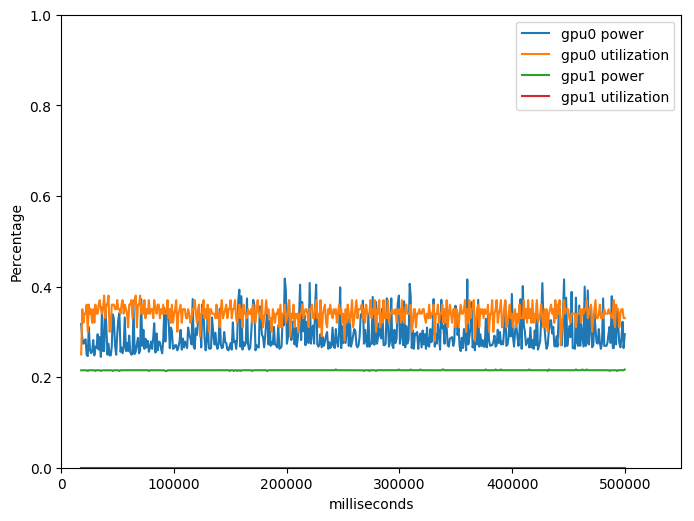

In [44]:
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np

plt.figure(figsize=(8,6), dpi=100)

samples = load_samples("cifar10_multi_gpu_samples.txt")
xs, ys = time_series(samples, 'gpu0', 'power_usage')
ys = ys / 150000.0
gpu0_power, = plt.plot(xs, ys, label='gpu0 power')

xs, ys = time_series(samples, 'gpu0', 'gpu_utilization')
ys = ys / 100.0
gpu0_utilization, = plt.plot(xs, ys, label='gpu0 utilization')

xs, ys = time_series(samples, 'gpu1', 'power_usage')
ys = ys / 150000.0
gpu1_power, = plt.plot(xs, ys, label='gpu1 power')

xs, ys = time_series(samples, 'gpu1', 'gpu_utilization')
ys = ys / 100.0
gpu1_utilization, = plt.plot(xs, ys, label='gpu1 utilization')

plt.legend(handles=[gpu0_power, gpu0_utilization, gpu1_power, gpu1_utilization])
plt.ylabel("Percentage")
plt.xlabel("milliseconds")
plt.axis([0, 550000, 0, 1])


### Scatter Plot Data

In this example, we will plot samples as milliwatts used by `gpu0`, respective to the number of training examples processed per second.

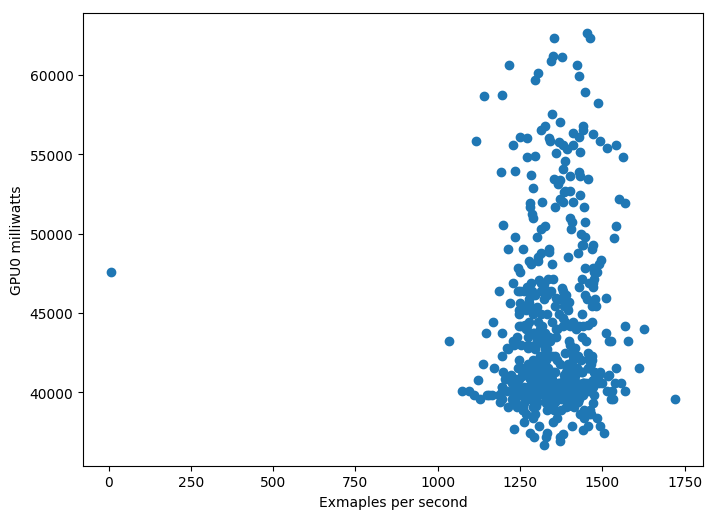

In [43]:
%matplotlib inline
from matplotlib import pyplot as plt

samples = load_samples("cifar10_multi_gpu_samples.txt")
xs, ys = scatter_points(samples, 'metadata', 'examples_sec', 'gpu0', 'power_usage')

plt.figure(figsize=(8, 6), dpi=100)
plt.scatter(xs, ys)
plt.xlabel("Exmaples per second")
plt.ylabel("GPU0 milliwatts")